# Data Analytics for ADAS assignment

Below you find three tasks and you should have been provided with a zip file that has all that you need, two csv's and one png.

For this assignment you should solve the tasks in the cells below(add as many cells as you want). Please document the code and your reasoning thoroughly. Rather too much than too little. It's not the solution itself that we care most about, rather how you attack the problem!

When you are done, download a copy of the notebook, zip it end email to therese.gardell@volvo.com.

Good luck!

## Task 1: Estimate time to collision for truck driving behind a moving car

**Objective:** In this coding test, you will be tasked with implementing a function that calculates the time to collision between two vehicles on a road. The scenario involves considering the acceleration of both the ego vehicle (your vehicle) and the vehicle in front of it. Your task is to complete the function and ensure that it accurately calculates the time to collision based on the provided inputs.

**Instructions:**


1.   You will find a partially implemented function named calculate_ttc_with_acceleration. Your task is to complete this function to calculate the time to collision in seconds.
2.   The function takes the following inputs:

  * `ego_velocity`: Initial velocity of the ego vehicle in meters per second (m/s).

  *   `ego_acceleration`: Constant acceleration of the ego vehicle, in meters per second squared (m/s^2).
  *   `front_vehicle_velocity`: Initial velocity of the vehicle in front of the ego vehicle, in m/s.
  * `front_vehicle_acceleration`: Constant acceleration of the vehicle in front of the ego vehicle, in m/s^2.
  * `distance_to_vehicle`: Initial distance to the vehicle in front, in meters (m).
3. You are expected to calculate the time to collision based on the provided inputs, considering both the ego vehicle's acceleration and the front vehicle's acceleration.

4. The function should return the calculated time to collision as a floating-point number.

5. You may assume that the ego vehicle and the front vehicle are moving along a straight road and that the respective acceleration is constant.

6. Handle the following scenarios:
  * If the time to collision is negative, return a string with "No collision possible (vehicles moving apart)."
  * Otherwise, return the calculated time to collision.
7. Test your implementation using the provided test cases. Each test case consists of initial velocities, accelerations, and initial distances. Your implementation should produce accurate time to collision results for the given test cases.

In [20]:
import math
import pandas as pd

def calculate_ttc_with_acceleration(ego_velocity, ego_acceleration, front_vehicle_velocity, front_vehicle_acceleration, distance_to_vehicle):
       # Calculate the relative velocity and acceleration
    relative_velocity = ego_velocity - front_vehicle_velocity
    relative_acceleration = ego_acceleration - front_vehicle_acceleration
    
    # Coefficients for the quadratic equation at^2 + bt + c = 0
    a = 0.5 * relative_acceleration
    b = relative_velocity
    c = -distance_to_vehicle
    
    # Calculate the discriminant
    discriminant = b**2 - 4*a*c
    
    # Check if collision is possible
    if discriminant < 0:
        return "No collision possible (vehicles moving apart)."
    elif discriminant == 0:
        # One real solution
        ttc = -b / (2*a) if a != 0 else -c / b
        return ttc if ttc >= 0 else "No collision possible (vehicles moving apart)."
    else:
        # Two real solutions
        sqrt_discriminant = math.sqrt(discriminant)
        t1 = (-b + sqrt_discriminant) / (2*a) if a != 0 else -c / b
        t2 = (-b - sqrt_discriminant) / (2*a) if a != 0 else -c / b
        
        # Select the smallest positive time to collision
        ttc = min(t for t in [t1, t2] if t >= 0)
        
        return ttc if ttc >= 0 else "No collision possible (vehicles moving apart)."


# Test cases
test_cases = [
    (10.0, 2.0, 8.0, 1.0, 20.0),  # Basic test case
    (15.0, 1.0, 20.0, -0.5, 30.0),  # Ego vehicle catching up with a vehicle that is deaccelerating
    (30.0, 0.0, 20.0, -20.0, 50.0), 
]

print('Test Results: ')
for idx, (ego_v, ego_a, front_v, front_a, distance) in enumerate(test_cases, start=1):
    time_to_collision = calculate_ttc_with_acceleration(ego_v, ego_a, front_v, front_a, distance)

    print('Test case {}'.format(idx))
    if isinstance(time_to_collision, str):
      print('Result is of type string')
      print(time_to_collision)
    elif isinstance(time_to_collision, float):
      print('Result is of type float')
      print(time_to_collision)
    else:
      print('Result is of type {}'.format(type(time_to_collision)))
      print(time_to_collision)



Test Results: 
Test case 1
Result is of type float
4.6332495807108
Test case 2
Result is of type float
10.482536863175739
Test case 3
Result is of type float
1.79128784747792


## Task 2: Visualize objects in bird's eye view

***Upload the provided zip-file 'DataAnalytics_test_files.zip' and extract files.***

**Task: Analyzing vehicle position data, computing bounding boxes and visualizing the vehicle environment**

You've been provided with a CSV file named "vehicle_data.csv" that contains information about the lateral and longitudinal positions of vehicles over time. The CSV file has the following columns:

`Timestamp`: The timestamp of the position measurement.

`Vehicle_ID`: The ID of the detected vehicle.

`Lateral_Position`: The lateral position of the vehicle on the road.

`Longitudinal_Position`: The longitudinal position of the vehicle on the road.

`Heading`: The heading direction of the vehicle in degrees, relative to the trucks' coordinate system.

`Width:` The width of the bounding box.

`Length`: The length of the bounding box.

Your extended task is to write a Python script that reads the CSV file, calculates bounding boxes for each vehicle based on heading and width/length and creates visualizations.

Specifically, you should:
* Read the CSV file and load the data into a suitable data structure (e.g. a Pandas DataFrame).
* Calculate bounding box coordinates for each vehicle based on heading and size.
* Create a plot to visualize the vehicle positions and their calculated bounding boxes.


Explain how you compute the bounding boxes and give some description to your visualizations and why you chose to do it in a certain way.

See how the coordinate system and objects are defined in the image below, the same image can be found in the attached zip-file 'DataAnalytics_test_files.zip'.

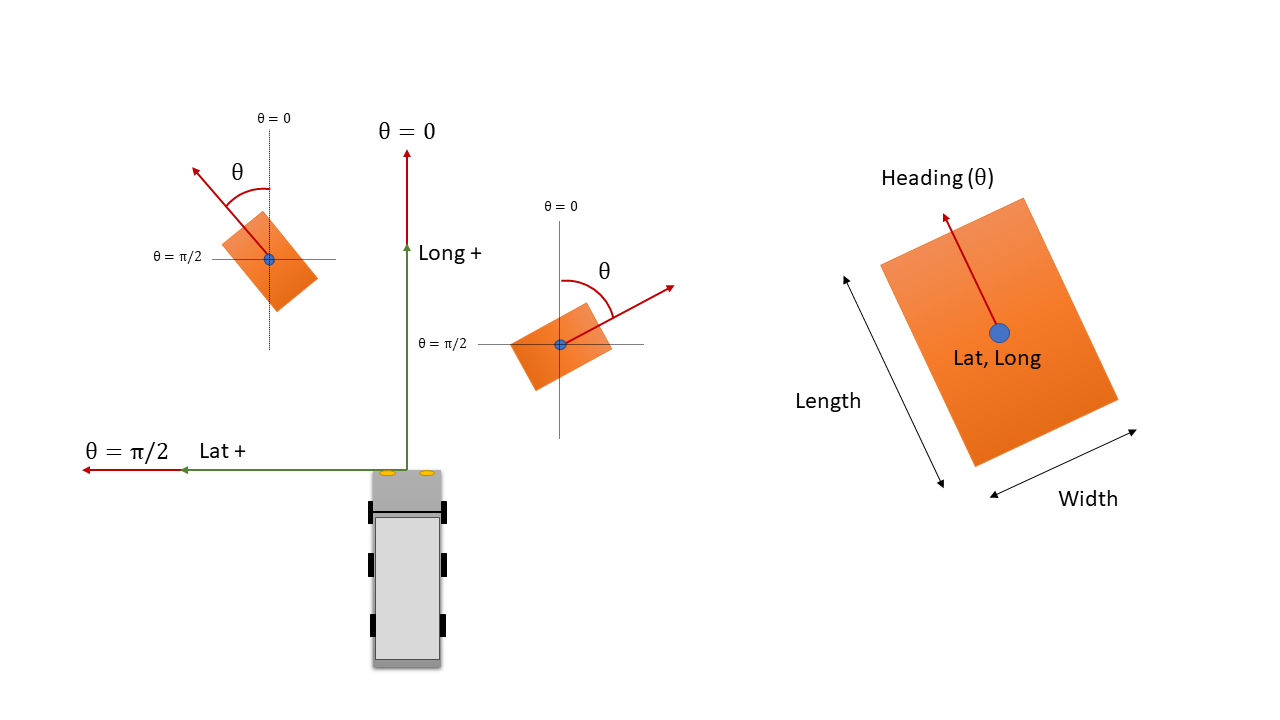

   Timestamp  Vehicle_ID  Lateral_Position  Longitudinal_Position  Heading  \
0          0           1               0.1                     10      -10   
1          0           2               3.0                      0        1   
2          0           3             -10.0                      5       80   
3          1           1               0.5                     13      -12   
4          1           2               3.0                      5        2   

   Width  Length  
0    3.0       5  
1    2.4       6  
2    3.1       6  
3    3.0       5  
4    2.4       6  


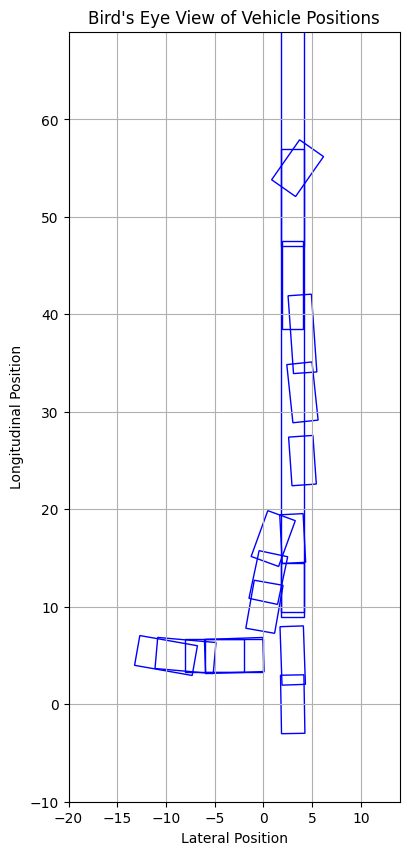

In [35]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Read csv file 'vehicle_data.csv', where each row represents a detection of a vehicle, at a given time
# The csv file uses delimiters ;
csv_file = 'DataAnalytics_test_files/vehicle_data.csv'
df = pd.read_csv(csv_file, delimiter=';')

# Check the data
print(df.head())

# Compute bounding boxes for each detection in the data
# Function to calculate bounding box corners
def calculate_bounding_box(x, y, width, length, heading):
    # Convert heading to radians
    theta = np.radians(heading)
    # Calculate corner points
    corner1 = (x - width/2, y - length/2)
    corner2 = (x + width/2, y - length/2)
    corner3 = (x + width/2, y + length/2)
    corner4 = (x - width/2, y + length/2)
    corners = [corner1, corner2, corner3, corner4]
    # Rotate corners
    rot_corners = []
    for cx, cy in corners:
        rx = np.cos(theta) * (cx - x) - np.sin(theta) * (cy - y) + x
        ry = np.sin(theta) * (cx - x) + np.cos(theta) * (cy - y) + y
        rot_corners.append((rx, ry))
    return rot_corners

# Calculate bounding boxes for each vehicle
df['BoundingBox'] = df.apply(lambda row: calculate_bounding_box(row['Lateral_Position'], row['Longitudinal_Position'], row['Width'], row['Length'], row['Heading']), axis=1)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
# Plot each vehicle
for index, row in df.iterrows():
    # Create a Polygon patch
    bbox = patches.Polygon(row['BoundingBox'], closed=True, color='blue', fill=False)
    # Add the patch to the Axes
    ax.add_patch(bbox)

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Set the plot limits to include all data points
ax.set_xlim(df['Lateral_Position'].min() - 10, df['Lateral_Position'].max() + 10)
ax.set_ylim(df['Longitudinal_Position'].min() - 10, df['Longitudinal_Position'].max() + 10)

# Set labels and title
ax.set_xlabel('Lateral Position')
ax.set_ylabel('Longitudinal Position')
ax.set_title('Bird\'s Eye View of Vehicle Positions')

# Show grid
ax.grid(True)

# Show the plot
plt.show()

fig.savefig('vehicle_positions.png', dpi=300)

## Task 3: Compare objects seen by sensor with ground truth

**Objective:** The objective of this task is to evaluate the accuracy and reliability of sensor-generated time-series data by comparing its object positions with the ground truth provided by a reference system. The sensor data and reference data are both comprised of lists of objects and their corresponding positions at each timestep.

You've been provided with two CSV files named "vehicle_data.csv" and "reference_data.csv". Both contains information about the lateral and longitudinal positions of vehicles over time, but from two different systems. The "vehicle_data.csv" has the data collected by an arbitrary sensor on the truck, and "reference_data.csv" has the ground truth data provided by a reference system.
In the reference data there is only one object present. A part of the task is figuring out which object in the sensor data corresponds with the object in the reference data.

How to do the evaluation is up to you! You can use math, plots and most important, your imagination!


**"reference_data.csv" has the following columns:**

`Timestamp`: The timestamp of the position measurement.

`Ref_ID`: The ID of the detected vehicle.

`Lateral_Position`: The lateral position of the vehicle on the road.

`Longitudinal_Position`: The longitudinal position of the vehicle on the road.

`Heading`: The heading direction of the vehicle in degrees.

`Width`: The width of the bounding box.

`Length`: The length of the bounding box.

**"vehicle_data.csv" has the following columns:**

`Timestamp`: The timestamp of the position measurement.

`Vehicle_ID`: The ID of the detected vehicle.

`Lateral_Position`: The lateral position of the vehicle on the road.

`Longitudinal_Position`: The longitudinal position of the vehicle on the road.

`Heading`: The heading direction of the vehicle in degrees.

`Width`: The width of the bounding box.

`Length`: The length of the bounding box.


**Start with loading the data**

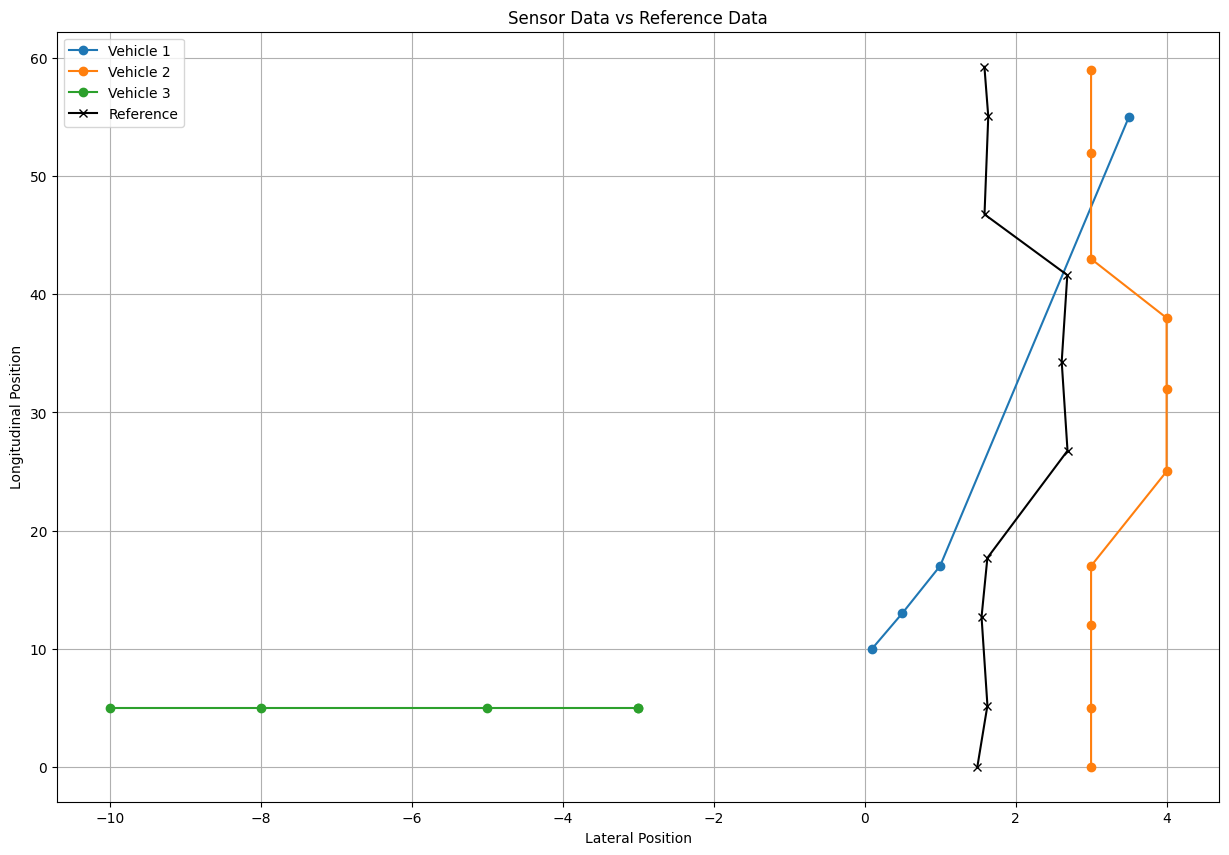

Vehicle 2 corresponds to the reference data.


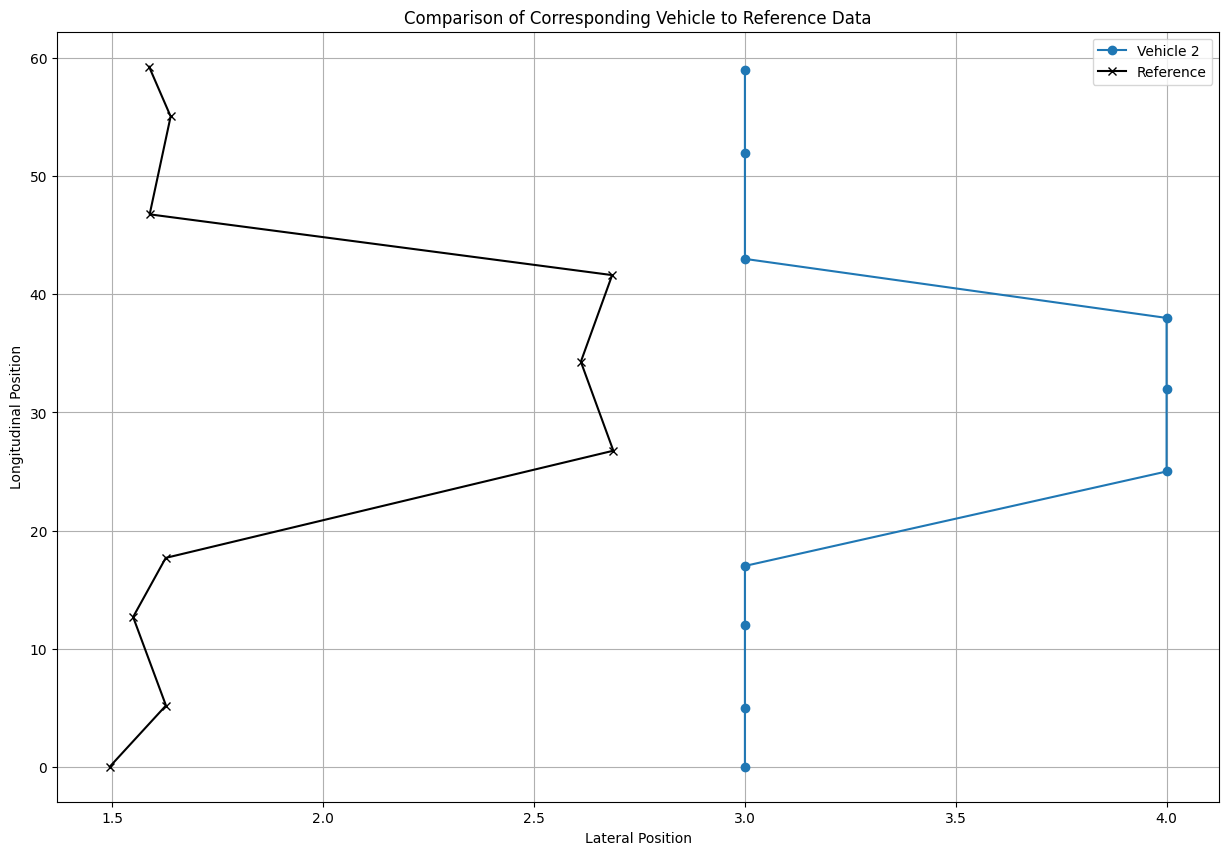

Mean Squared Error (Lateral): 1.9370710964955067
Mean Squared Error (Longitudinal): 4.610853822226474
Mean Absolute Error (Lateral): 1.3906610873630776
Mean Absolute Error (Longitudinal): 1.6320656985794941


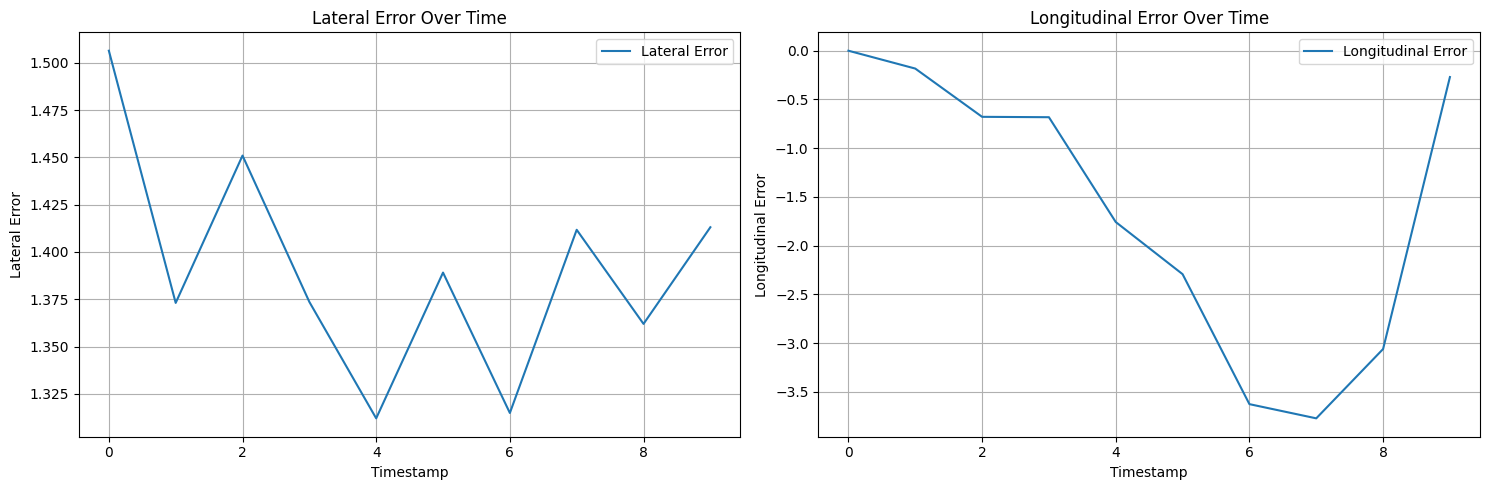

Summary Statistics for Lateral Errors:
count    10.000000
mean      1.390661
std       0.058999
min       1.312019
25%       1.364725
50%       1.381330
75%       1.412718
max       1.506379
Name: Lateral_Error, dtype: float64

Summary Statistics for Longitudinal Errors:
count    10.000000
mean     -1.632066
std       1.470909
min      -3.771336
25%      -2.868223
50%      -1.219790
75%      -0.372181
max       0.000000
Name: Longitudinal_Error, dtype: float64


In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Read csv file 'vehicle_data.csv', where each row represents a detection of a vehicle, at a given time
# The csv files use delimeters ;
vehicle_csv_file = 'DataAnalytics_test_files/vehicle_data.csv'
reference_csv_file  = 'DataAnalytics_test_files/reference_data.csv'

# TODO: the rest.


# Load the data into Pandas DataFrames
vehicle_data = pd.read_csv(vehicle_csv_file, delimiter=';')
reference_data = pd.read_csv(reference_csv_file, delimiter=';')

# Visualize the data
plt.figure(figsize=(15, 10))

# Plot vehicle data
for vehicle_id in vehicle_data['Vehicle_ID'].unique():
    vehicle_positions = vehicle_data[vehicle_data['Vehicle_ID'] == vehicle_id]
    plt.plot(vehicle_positions['Lateral_Position'], vehicle_positions['Longitudinal_Position'], marker='o', label=f'Vehicle {vehicle_id}')

# Plot reference data
plt.plot(reference_data['Lateral_Position'], reference_data['Longitudinal_Position'], marker='x', color='k', label='Reference')

plt.xlabel('Lateral Position')
plt.ylabel('Longitudinal Position')
plt.title('Sensor Data vs Reference Data')
plt.legend()
plt.grid(True)
plt.show()


# Load the data into Pandas DataFrames
vehicle_data = pd.read_csv(vehicle_csv_file, delimiter=';')
reference_data = pd.read_csv(reference_csv_file, delimiter=';')

# Function to calculate Euclidean distance
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Initialize a dictionary to hold the cumulative distance for each vehicle
cumulative_distances = {}

# Calculate the cumulative distance for each vehicle
for vehicle_id in vehicle_data['Vehicle_ID'].unique():
    # Skip vehicle 3 as it is far from the others
    if vehicle_id == 3:
        continue
    
    # Get the positions of the current vehicle
    vehicle_positions = vehicle_data[vehicle_data['Vehicle_ID'] == vehicle_id]
    
    # Calculate the distance at each timestamp and sum them
    total_distance = 0
    for _, vehicle_row in vehicle_positions.iterrows():
        # Find the reference data for the same timestamp
        reference_row = reference_data[reference_data['Timestamp'] == vehicle_row['Timestamp']]
        if not reference_row.empty:
            distance = euclidean_distance(
                vehicle_row['Lateral_Position'], vehicle_row['Longitudinal_Position'],
                reference_row['Lateral_Position'].values[0], reference_row['Longitudinal_Position'].values[0]
            )
            total_distance += distance
    
    # Store the cumulative distance
    cumulative_distances[vehicle_id] = total_distance

# Determine the vehicle with the smallest cumulative distance
corresponding_vehicle_id = min(cumulative_distances, key=cumulative_distances.get)
print(f"Vehicle {corresponding_vehicle_id} corresponds to the reference data.")

# Visualize the corresponding vehicle and reference data for comparison
plt.figure(figsize=(15, 10))
vehicle_positions = vehicle_data[vehicle_data['Vehicle_ID'] == corresponding_vehicle_id]
plt.plot(vehicle_positions['Lateral_Position'], vehicle_positions['Longitudinal_Position'], marker='o', label=f'Vehicle {corresponding_vehicle_id}')
plt.plot(reference_data['Lateral_Position'], reference_data['Longitudinal_Position'], marker='x', color='k', label='Reference')

plt.xlabel('Lateral Position')
plt.ylabel('Longitudinal Position')
plt.title('Comparison of Corresponding Vehicle to Reference Data')
plt.legend()
plt.grid(True)
plt.show()


# Assuming vehicle_data and reference_data are already loaded into DataFrames

# Isolate the data for Vehicle 2
vehicle_2_data = vehicle_data[vehicle_data['Vehicle_ID'] == 2]

# Align the timestamps by merging the two datasets on the 'Timestamp' column
aligned_data = pd.merge(vehicle_2_data, reference_data, on='Timestamp', suffixes=('_sensor', '_ref'))

# Calculate the differences in positions
aligned_data['Lateral_Diff'] = aligned_data['Lateral_Position_sensor'] - aligned_data['Lateral_Position_ref']
aligned_data['Longitudinal_Diff'] = aligned_data['Longitudinal_Position_sensor'] - aligned_data['Longitudinal_Position_ref']

# Calculate MSE
mse_lateral = (aligned_data['Lateral_Diff'] ** 2).mean()
mse_longitudinal = (aligned_data['Longitudinal_Diff'] ** 2).mean()

# Calculate MAE
mae_lateral = aligned_data['Lateral_Diff'].abs().mean()
mae_longitudinal = aligned_data['Longitudinal_Diff'].abs().mean()

# Print the results
print(f'Mean Squared Error (Lateral): {mse_lateral}')
print(f'Mean Squared Error (Longitudinal): {mse_longitudinal}')
print(f'Mean Absolute Error (Lateral): {mae_lateral}')
print(f'Mean Absolute Error (Longitudinal): {mae_longitudinal}')

# Calculate the time-wise error between Vehicle 2 sensor data and reference data
aligned_data['Lateral_Error'] = aligned_data['Lateral_Position_sensor'] - aligned_data['Lateral_Position_ref']
aligned_data['Longitudinal_Error'] = aligned_data['Longitudinal_Position_sensor'] - aligned_data['Longitudinal_Position_ref']

# Plot the errors over time
plt.figure(figsize=(15, 5))

# Plot Lateral Error
plt.subplot(1, 2, 1)
plt.plot(aligned_data['Timestamp'], aligned_data['Lateral_Error'], label='Lateral Error')
plt.xlabel('Timestamp')
plt.ylabel('Lateral Error')
plt.title('Lateral Error Over Time')
plt.legend()
plt.grid(True)

# Plot Longitudinal Error
plt.subplot(1, 2, 2)
plt.plot(aligned_data['Timestamp'], aligned_data['Longitudinal_Error'], label='Longitudinal Error')
plt.xlabel('Timestamp')
plt.ylabel('Longitudinal Error')
plt.title('Longitudinal Error Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Print out summary statistics for lateral error
print("Summary Statistics for Lateral Errors:")
print(aligned_data['Lateral_Error'].describe())

# Print out summary statistics for longitudinal error
print("\nSummary Statistics for Longitudinal Errors:")
print(aligned_data['Longitudinal_Error'].describe())

